## Collecting data from gnomAD

Variants data downloaded from [gnomAD](https://gnomad.broadinstitute.org/downloads#v4)

Use command line for initial processing

1. Filtered only PASS variants 

```zsh
bcftools view -f 'PASS,.' gnomad.exomes.v4.0.sites.chr22.vcf.bgz > filtered_gnomad22.bgz
```
For next parcing we can use also **command line** or **python**

2. Extract the necessary data

for this step we need **bcftools** utility

```zsh
bcftools query -f '%CHROM\t%POS\t%ID\t%REF\t%ALT\t%AC\t%AC_afr\t%AC_amr\t%AC_nfe
\t%AC_asj\t%AC_sas\t%AC_eas\t%AC_mid\t%AC_fin\t%AN\t%AN_afr\t%AN_amr\t%AN_nfe\t%AN_asj
\t%AN_sas\t%AN_eas\t%AN_mid\t%AN_fin\t%AF\t%AF_afr\t%AF_amr\t%AF_nfe\t%AF_asj\t%AF_sas
\t%AF_eas\t%AF_mid\t%AF_fin\t%vep=\n' filtered_gnomad22.bgz > processed_gnomad22.vcf.bgz
```


In [67]:
import csv

import cyvcf2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
vcf_path = 'data/gnomad.exomes.v4.0.sites.chr22.vcf.bgz'
vcf = cyvcf2.VCF(vcf_path)

# Define the columns to extract
info_fields_to_extract = ['AC', 'AC_afr', 'AC_amr', 'AC_nfe', 'AC_asj', 'AC_sas', 'AC_eas', 'AC_mid', 'AC_fin',
               'AN', 'AN_afr', 'AN_amr', 'AN_nfe', 'AN_asj', 'AN_sas', 'AN_eas', 'AN_mid', 'AN_fin',
               'AF', 'AF_afr', 'AF_amr', 'AF_nfe', 'AF_asj', 'AF_sas', 'AF_eas', 'AF_mid', 'AF_fin', 'vep']
vep_field_mapping = {
        1: 'Consequence', 3: 'SYMBOL',
        5: 'Feature_Type', 6: 'Feature', 7: 'BIOTYPE', 8: 'EXON', 9: 'INTRON',
        17: 'ALLELE_NUM', 24: 'CANONICAL',
        42: 'LoF', 43: 'LoF_filter', 44: 'LoF_flags', 45: 'LoF_info'}

column_names = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'AC', 'AC_afr', 'AC_amr', 'AC_nfe', 'AC_asj', 
                'AC_sas', 'AC_eas', 'AC_mid', 'AC_fin',
                'AN', 'AN_afr', 'AN_amr', 'AN_nfe', 'AN_asj', 'AN_sas', 'AN_eas', 'AN_mid', 'AN_fin',
                'AF', 'AF_afr', 'AF_amr', 'AF_nfe', 'AF_asj', 'AF_sas', 'AF_eas', 'AF_mid', 'AF_fin',
                'Consequence', 'SYMBOL', 'Feature_Type', 'Feature', 'BIOTYPE', 'EXON', 'INTRON', 'ALLELE_NUM',
                'CANONICAL', 'LoF', 'LoF_filter', 'LoF_flags', 'LoF_info']

# Initialize an empty list to store the extracted data
data = []

# Iterate over each variant in the VCF file
counter = 1
for variant in vcf:
    variant_data = [variant.CHROM, variant.POS, variant.ID, variant.REF, variant.ALT[0]]
    info_data = [variant.INFO.get(field, '.') for field in info_fields_to_extract]
    vep_annotation = variant.INFO.get('vep')

    # Handle multiple transcripts in vep if present
    if vep_annotation:
        vep_transcripts = vep_annotation.split(',')
        for transcript in vep_transcripts:
            split_transcript = transcript.split('|')
            vep_fields = []
            for key in vep_field_mapping.keys():
                try:
                    vep_fields.append(split_transcript[key])
                except:
                    vep_fields.append('.')
            data.append(variant_data + info_data[:-1] + vep_fields)
    else:
        data.append(variant_data + info_data + ['.'])
    counter += 1
output_file_name = f"output_{vcf_path.split('.')[-3]}.tsv"
with open(output_file_name, 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    # Write the header
    writer.writerow(column_names)
    # Write the data rows
    writer.writerows(data)
# Create a pandas DataFrame from the extracted data

KeyboardInterrupt: 

Проверка на тестовых данных 17.03.2024

Порядок работы:

1. **Фильтруем по статусу PASS**

```zsh
bcftools view -f 'PASS,.' gnomad.exomes.v4.0.sites.chr22.vcf.bgz > filtered_gnomad22.bgz
```
Уже получается распакованный архив

2. **Дальше запускаем наш парсер и записываем либо файл, либо сразу датафрейм.**

3. Пытаемся понять **суммарный AC по каждому белок-кодирующему транскрипту c потерей функции** на игрушечном наборе данных из хромосомы 22 (25 тысяч строк в начале файла + 25 тысяч строк с конца файла)

>Значение AC (Количество аллелей) в GnomeAD — это мера того, сколько людей в базе данных имеют аллель (вариантную форму) для определенного гена в указанной позиции. Значение AC находится в диапазоне от 0 до n, где n — общее количество людей в базе данных, чьи геномные данные доступны. Более высокие значения AC могут указывать на то, что вариант распространен, а более низкие значения предполагают, что вариант редок или отсутствует.

```zsh
protein_transcript_df = vcf_df[
    (vcf_df['Feature_Type'] == 'Transcript') & 
    (vcf_df['BIOTYPE'] == 'protein_coding') &
    (vcf_df['Consequence'] == 'stop_gained')
    ]
```
Получилось 1220 записей

Посмотрим, сколько уникальных транскриптов:

```zsh
protein_transcript_df['Feature'].nunique()
```

Получилось 104 трансрипта

Смотрим сумму AC по уникальным транскриптам:

```zsh
sum_ac_per_transcript = protein_transcript_df.groupby('Feature')['AC'].sum()
```
Нашли транскрипт с самой высокой суммой:

```zsh
transcript_with_max_ac = sum_ac_per_transcript.idxmax()
max_ac_sum = sum_ac_per_transcript.max()

print("Transcript with the largest sum of AC values:", transcript_with_max_ac)
print("Largest sum of AC values:", max_ac_sum)

#Transcript with the largest sum of AC values: ENST00000643316
#Largest sum of AC values: 731224
```
Этот транскрипт гена **GAB4**

Какие мутации с потерей функции в этом гене очень распространены в популяциях:

* AC = 177956, G -> A, intron 4/10
* AC = 553208, C -> A, intron 3/10
* AC = 30, G -> A, intron 4/10

В этих случаях возникает укороченный вариант белка, но, похоже, это не очень влияет на его функциональную значимость

In [9]:
vcf_path = '/home/irina/BI_projects/genetic_variance/data/processed_data/test_chr22_50k.vcf'
vcf = cyvcf2.VCF(vcf_path)

# Define the columns to extract
info_fields_to_extract = ['AC', 'AC_afr', 'AC_amr', 'AC_nfe', 'AC_asj', 'AC_sas', 'AC_eas', 'AC_mid', 'AC_fin',
               'AN', 'AN_afr', 'AN_amr', 'AN_nfe', 'AN_asj', 'AN_sas', 'AN_eas', 'AN_mid', 'AN_fin',
               'AF', 'AF_afr', 'AF_amr', 'AF_nfe', 'AF_asj', 'AF_sas', 'AF_eas', 'AF_mid', 'AF_fin', 'vep']
vep_field_mapping = {
        1: 'Consequence', 3: 'SYMBOL',
        5: 'Feature_Type', 6: 'Feature', 7: 'BIOTYPE', 8: 'EXON', 9: 'INTRON',
        17: 'ALLELE_NUM', 21: 'VARIANT_CLASS', 24: 'CANONICAL',
        42: 'LoF', 43: 'LoF_filter', 44: 'LoF_flags', 45: 'LoF_info'}

column_names = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'AC', 'AC_afr', 'AC_amr', 'AC_nfe', 'AC_asj', 
                'AC_sas', 'AC_eas', 'AC_mid', 'AC_fin',
                'AN', 'AN_afr', 'AN_amr', 'AN_nfe', 'AN_asj', 'AN_sas', 'AN_eas', 'AN_mid', 'AN_fin',
                'AF', 'AF_afr', 'AF_amr', 'AF_nfe', 'AF_asj', 'AF_sas', 'AF_eas', 'AF_mid', 'AF_fin',
                'Consequence', 'SYMBOL', 'Feature_Type', 'Feature', 'BIOTYPE', 'EXON', 'INTRON', 'ALLELE_NUM',
                'VARIANT_CLASS', 'CANONICAL', 'LoF', 'LoF_filter', 'LoF_flags', 'LoF_info']

# Initialize an empty list to store the extracted data
data = []

# Iterate over each variant in the VCF file
counter = 1
for variant in vcf:
    variant_data = [variant.CHROM, variant.POS, variant.ID, variant.REF, variant.ALT[0]]
    info_data = [variant.INFO.get(field, '.') for field in info_fields_to_extract]
    vep_annotation = variant.INFO.get('vep')

    # Handle multiple transcripts in vep if present
    if vep_annotation:
        vep_transcripts = vep_annotation.split(',')
        for transcript in vep_transcripts:
            split_transcript = transcript.split('|')
            vep_fields = []
            for key in vep_field_mapping.keys():
                try:
                    vep_fields.append(split_transcript[key])
                except:
                    vep_fields.append('.')
            data.append(variant_data + info_data[:-1] + vep_fields)
    else:
        data.append(variant_data + info_data + ['.'])
    counter += 1
vcf_df = pd.DataFrame(data, columns=column_names)

In [18]:
transcript_df = vcf_df[vcf_df['Feature_Type'] == 'Transcript']

In [28]:
protein_transcript_df = vcf_df[
    (vcf_df['Feature_Type'] == 'Transcript') & 
    (vcf_df['BIOTYPE'] == 'protein_coding') &
    (vcf_df['Consequence'] == 'stop_gained')
    ]

In [30]:
protein_transcript_df.columns

Index(['CHROM', 'POS', 'ID', 'REF', 'ALT', 'AC', 'AC_afr', 'AC_amr', 'AC_nfe',
       'AC_asj', 'AC_sas', 'AC_eas', 'AC_mid', 'AC_fin', 'AN', 'AN_afr',
       'AN_amr', 'AN_nfe', 'AN_asj', 'AN_sas', 'AN_eas', 'AN_mid', 'AN_fin',
       'AF', 'AF_afr', 'AF_amr', 'AF_nfe', 'AF_asj', 'AF_sas', 'AF_eas',
       'AF_mid', 'AF_fin', 'Consequence', 'SYMBOL', 'Feature_Type', 'Feature',
       'BIOTYPE', 'EXON', 'INTRON', 'ALLELE_NUM', 'VARIANT_CLASS', 'CANONICAL',
       'LoF', 'LoF_filter', 'LoF_flags', 'LoF_info'],
      dtype='object')

In [43]:
protein_transcript_df['Feature'].unique()

array(['ENST00000643195', 'NM_001005239.2', 'ENST00000343518',
       'NM_001136213.1', 'ENST00000359963', 'NM_014406.5',
       'ENST00000331428', 'ENST00000684488', 'NM_001318251.3',
       'NM_001386955.1', 'NM_001386956.1', 'NM_001386957.1',
       'NM_175878.5', 'ENST00000400588', 'ENST00000643316',
       'NM_001037814.1', 'NM_001366857.1', 'XM_011546114.2',
       'XM_011546115.1', 'XM_011546117.1', 'XM_017028575.1',
       'XM_017028576.1', 'XM_011546116.2', 'ENST00000312108',
       'ENST00000360719', 'ENST00000395650', 'ENST00000405237',
       'ENST00000457250', 'NM_001145134.2', 'NM_001145135.2',
       'NM_001145137.2', 'NM_004377.4', 'NM_152245.3', 'NM_152246.3',
       'ENST00000417176', 'ENST00000406938', 'NM_005198.5',
       'ENST00000329492', 'NM_012324.6', 'XM_011530679.2',
       'XM_011530680.2', 'XM_011530681.2', 'ENST00000216124',
       'ENST00000356098', 'ENST00000395619', 'ENST00000395621',
       'ENST00000453344', 'NM_000487.6', 'NM_001085425.3',
       'NM

In [49]:
sum_ac_per_transcript = protein_transcript_df.groupby('Feature')['AC'].sum()

In [54]:
transcript_with_max_ac = sum_ac_per_transcript.idxmax()
max_ac_sum = sum_ac_per_transcript.max()

print("Transcript with the largest sum of AC values:", transcript_with_max_ac)
print("Largest sum of AC values:", max_ac_sum)

Transcript with the largest sum of AC values: ENST00000643316
Largest sum of AC values: 731224


In [66]:
protein_transcript_df[protein_transcript_df['Feature'] == 'ENST00000643316']

,CHROM,POS,ID,REF,ALT,AC,AC_afr,AC_amr,AC_nfe,AC_asj,...,BIOTYPE,EXON,INTRON,ALLELE_NUM,VARIANT_CLASS,CANONICAL,LoF,LoF_filter,LoF_flags,LoF_info
75381,chr22,16962810,None,G,A,1,0,0,1,0,...,protein_coding,10/10,,1,SNV,,,,HC,
80605,chr22,16963786,rs201165731,G,C,1,0,0,0,0,...,protein_coding,9/10,,1,SNV,,,,HC,
93703,chr22,16966169,None,G,A,1,0,1,0,0,...,protein_coding,6/10,,1,SNV,,,,HC,
106643,chr22,16969625,rs2041607,G,A,177956,2803,9450,102725,6018,...,protein_coding,4/10,,1,SNV,,,,HC,
107531,chr22,16969730,rs766763376,G,A,30,0,1,29,0,...,protein_coding,4/10,,1,SNV,,,,HC,
116967,chr22,16987979,rs1045885030,G,A,1,1,0,0,0,...,protein_coding,3/10,,1,SNV,,,,HC,
117147,chr22,16987991,rs763795980,G,A,8,0,0,6,0,...,protein_coding,3/10,,1,SNV,,,,HC,
117364,chr22,16987996,rs61743894,G,T,3,0,0,1,0,...,protein_coding,3/10,,1,SNV,,,,HC,
118461,chr22,16988078,rs1196516899,G,A,5,0,5,0,0,...,protein_coding,3/10,,1,SNV,,,,HC,
118539,chr22,16988084,rs1032243450,G,A,4,0,1,2,0,...,protein_coding,3/10,,1,SNV,,,,HC,


In [69]:
sum_ac_per_transcript.min()

2

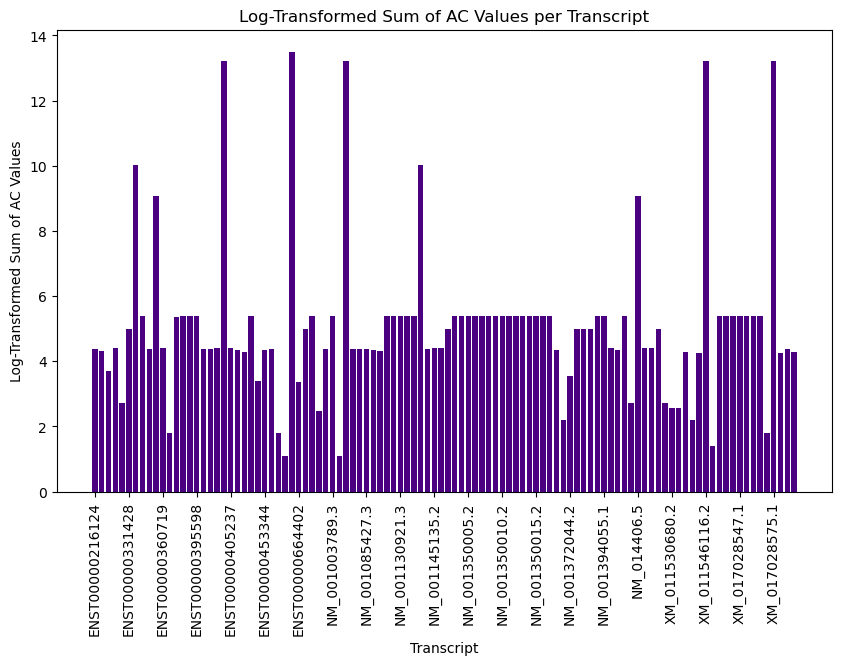

In [78]:
normalized_data = np.log1p(sum_ac_per_transcript)

# Create a histogram of the log-transformed data
plt.figure(figsize=(10, 6))
plt.bar(range(len(normalized_data)), normalized_data, color='indigo')
plt.xlabel('Transcript')
plt.ylabel('Log-Transformed Sum of AC Values')
plt.title('Log-Transformed Sum of AC Values per Transcript')
plt.xticks(range(0, len(normalized_data), 5), list(normalized_data.index[::5]), rotation=90)
plt.show()